## Imports

In [1]:
import os
from dotenv import load_dotenv
import httpx
import pandas as pd
import requests
import datetime
import json
from urllib.request import Request, urlopen
import random
import datetime
import missingno as msno

load_dotenv()
weather_api_key = os.getenv("weather_api_key")
pressure_api_key = os.getenv("pressure_api_key")
flight_api_key = os.getenv("flight_api_key")

## Variables and Maps

In [2]:
selected_airports_iata = [
    "DTW",
    "LAS",
    "PHL",
    "DEN",
    "CLT",
    "SEA",
    "MCO",
    "FLL",
    "IAD",
    "IAH",
    "SFO",
    "EWR",
    "MIA",
    "JFK",
    "LAX",
    "ORD",
    "ATL",
]
icao_to_iata_map = {
    "KDTW": "DTW",
    "KLAS": "LAS",
    "KPHL": "PHL",
    "KDEN": "DEN",
    "KCLT": "CLT",
    "KSEA": "SEA",
    "KMCO": "MCO",
    "KFLL": "FLL",
    "KIAD": "IAD",
    "KIAH": "IAH",
    "KSFO": "SFO",
    "KEWR": "EWR",
    "KMIA": "MIA",
    "KJFK": "JFK",
    "KLAX": "LAX",
    "KORD": "ORD",
    "KATL": "ATL",
}
iata_to_icao_map = {v: k for k, v in icao_to_iata_map.items()}
wac_map = {
    "BOS": 13,
    "CLT": 36,
    "DEN": 82,
    "DTW": 43,
    "EWR": 21,
    "FLL": 33,
    "IAD": 38,
    "IAH": 74,
    "JFK": 22,
    "LAS": 85,
    "LAX": 91,
    "MCO": 33,
    "MIA": 33,
    "ORD": 41,
    "PHL": 23,
    "SEA": 93,
    "SFO": 91,
    "ATL": 34,
}
weather_features = [
    ("dewpoint", "value"),
    "relative_humidity",
    ("remarks_info", "precip_hourly", "value"),
    ("remarks_info", "temperature_decimal", "value"),
    ("visibility", "value"),
    ("wind_direction", "value"),
    ("wind_gust", "value"),
    ("wind_speed", "value"),
]
pressure_features = [("pressure", "hg")]
flight_features = [
    "flight_date",
    ("departure", "iata"),
    ("departure", "delay"),
    ("departure", "scheduled"),
    ("arrival", "iata"),
    ("arrival", "delay"),
    ("arrival", "scheduled"),
]

## Weather data (no pressure data)

In [3]:
responses = {}
for airport in selected_airports_iata:
    print(f"Getting weather for {airport}")
    request = Request(
        f"https://avwx.rest/api/metar/{iata_to_icao_map[airport]}",
        headers={"Authorization": weather_api_key},
    )
    response_body = urlopen(request).read()
    response_json = json.loads(response_body)
    responses[airport] = response_json

weather_data = []

for airport in selected_airports_iata:
    response_json = responses[airport]
    data = {"airport": airport}
    data["HourlyDewPointTemperature"] = response_json["remarks_info"][
        "dewpoint_decimal"
    ]["value"]
    data["HourlyRelativeHumidity"] = response_json["relative_humidity"]
    if response_json["remarks_info"]["precip_hourly"] is not None:
        data["HourlyPrecipitation"] = response_json["remarks_info"]["precip_hourly"][
            "value"
        ]
    else:
        data["HourlyPrecipitation"] = 0
    data["HourlyDryBulbTemperature"] = response_json["remarks_info"][
        "temperature_decimal"
    ]["value"]
    data["HourlyVisibility"] = response_json["visibility"]["value"]
    data["HourlyWindDirection"] = response_json["wind_direction"]["value"]
    if response_json["wind_gust"] is not None:
        data["HourlyWindGustSpeed"] = response_json["wind_gust"]["value"]
    else:
        data["HourlyWindGustSpeed"] = 0
    data["HourlyWindSpeed"] = response_json["wind_speed"]["value"]
    weather_data.append(data)

weather_data = pd.DataFrame(weather_data)
weather_data.head()

Getting weather for DTW
Getting weather for LAS
Getting weather for PHL
Getting weather for DEN
Getting weather for CLT
Getting weather for SEA
Getting weather for MCO
Getting weather for FLL
Getting weather for IAD
Getting weather for IAH
Getting weather for SFO
Getting weather for EWR
Getting weather for MIA
Getting weather for JFK
Getting weather for LAX
Getting weather for ORD
Getting weather for ATL


,airport,HourlyDewPointTemperature,HourlyRelativeHumidity,HourlyPrecipitation,HourlyDryBulbTemperature,HourlyVisibility,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed
0,DTW,6.7,0.927489,0.00,7.8,6.00,310.0,0,6
1,LAS,-5.0,0.464089,0.00,5.6,10.00,220.0,0,4
2,PHL,6.7,0.966284,0.01,7.2,6.00,80.0,0,5
3,DEN,-9.4,0.372296,0.00,3.9,10.00,350.0,0,13
4,CLT,13.3,0.931031,0.01,14.4,0.75,330.0,0,5


## Barometric pressure data

In [4]:
url = "https://api.checkwx.com/metar/KJFK/decoded"

response = requests.request("GET", url, headers={"X-API-Key": pressure_api_key})

for airport in selected_airports_iata:
    print(f"Getting pressure for {airport}")
    request = Request(
        f"https://api.checkwx.com/metar/{iata_to_icao_map[airport]}/decoded",
        headers={"X-API-Key": pressure_api_key},
    )
    response_body = urlopen(request).read()
    response_json = json.loads(response_body)
    responses[airport] = response_json

pressure_data = []

for airport in selected_airports_iata:
    response_json = responses[airport]
    data = {"airport": airport}
    data["HourlyStationPressure"] = response_json["data"][0]["barometer"]["hg"]
    pressure_data.append(data)

pressure_data = pd.DataFrame(pressure_data)
pressure_data.head()

Getting pressure for DTW
Getting pressure for LAS
Getting pressure for PHL
Getting pressure for DEN
Getting pressure for CLT
Getting pressure for SEA
Getting pressure for MCO
Getting pressure for FLL
Getting pressure for IAD
Getting pressure for IAH
Getting pressure for SFO
Getting pressure for EWR
Getting pressure for MIA
Getting pressure for JFK
Getting pressure for LAX
Getting pressure for ORD
Getting pressure for ATL


,airport,HourlyStationPressure
0,DTW,29.93
1,LAS,30.22
2,PHL,30.11
3,DEN,30.06
4,CLT,29.86


## Flight data

In [5]:
endpoint = "http://api.aviationstack.com/v1/flights"
flight_data = []

for i in range(len(selected_airports_iata)):
    print(f"Getting flights for {selected_airports_iata[i]}")
    # Parameters for the API request
    rand_int = random.randint(0, len(selected_airports_iata) - 1)
    params = {
        "access_key": flight_api_key,
        "dep_iata": selected_airports_iata[i],  # Replace 'SFO' with your desired airport code
        'arr_iata': selected_airports_iata[rand_int],
    }

    # Making the GET request
    response = requests.get(endpoint, params=params)
    # Checking if the request was successful (status code 200)
    if response.status_code == 200:
        response = response.json()  # Parsing the JSON response
        # Handle and process 'data' (flight information)
        data = {"airport": selected_airports_iata[i]}
        if len(response["data"]) == 0:
            continue
        rand_int = random.randint(0, len(response["data"]) - 1)
        response = response["data"][rand_int]
        data["FL_DATE"] =  response["flight_date"]
        data["ORIGIN"] = response["departure"]["iata"]
        if response["departure"]["delay"] is not None:
            data["DEP_DELAY_NEW"] = response["departure"]["delay"]
        else:
            data["DEP_DELAY_NEW"] = 0.0
        data["DEPARTURE_DATETIME"] = response["departure"]["scheduled"]
        data["DEST"] = response["arrival"]["iata"]
        data["CRS_ARR_TIME"] = response["arrival"]["scheduled"]
        flight_data.append(data)
    else:
        print("Request failed:", response.status_code)

flight_data = pd.DataFrame(flight_data)
flight_data.head()


Getting flights for DTW
Getting flights for LAS
Getting flights for PHL
Getting flights for DEN
Getting flights for CLT
Getting flights for SEA
Getting flights for MCO
Getting flights for FLL
Getting flights for IAD
Getting flights for IAH
Getting flights for SFO
Getting flights for EWR
Getting flights for MIA
Getting flights for JFK
Getting flights for LAX
Getting flights for ORD
Getting flights for ATL


,airport,FL_DATE,ORIGIN,DEP_DELAY_NEW,DEPARTURE_DATETIME,DEST,CRS_ARR_TIME
0,DTW,2023-12-26,DTW,15,2023-12-26T16:40:00+00:00,SEA,2023-12-26T18:50:00+00:00
1,PHL,2023-12-26,PHL,64,2023-12-26T13:55:00+00:00,MCO,2023-12-26T16:39:00+00:00
2,DEN,2023-12-26,DEN,43,2023-12-26T18:57:00+00:00,EWR,2023-12-27T00:41:00+00:00
3,CLT,2023-12-26,CLT,16,2023-12-26T07:26:00+00:00,LAX,2023-12-26T10:00:00+00:00
4,SEA,2023-12-26,SEA,24,2023-12-26T08:04:00+00:00,IAD,2023-12-26T15:58:00+00:00


## Merging the data

In [6]:
weather_delay_data = pd.merge(weather_data, flight_data, on="airport")
weather_delay_data = pd.merge(weather_delay_data, pressure_data, on="airport")

## Transformation

In [7]:

# drop airport column
weather_delay_data = weather_delay_data.drop(columns=["airport"])

# Transform DEST and ORIGIN to string
weather_delay_data["DEST"] = weather_delay_data["DEST"].astype(str)
weather_delay_data["ORIGIN"] = weather_delay_data["ORIGIN"].astype(str)

# add wac code to weather_delay_data
weather_delay_data["DEST_WAC"] = weather_delay_data["DEST"].map(wac_map)
weather_delay_data["ORIGIN_WAC"] = weather_delay_data["ORIGIN"].map(wac_map)

# Transform date columns to datetime
weather_delay_data["FL_DATE"] = pd.to_datetime(weather_delay_data["FL_DATE"])
weather_delay_data["DEPARTURE_DATETIME"] = pd.to_datetime(
    weather_delay_data["DEPARTURE_DATETIME"]
)

weather_delay_data["CRS_DEP_TIME"] = pd.to_datetime(
    weather_delay_data["DEPARTURE_DATETIME"]
).dt.time

# change  CRS_DEP_TIME to the format HHMM
weather_delay_data["CRS_DEP_TIME"] = weather_delay_data["CRS_DEP_TIME"].apply(
    lambda x: x.strftime("%H%M")
)

weather_delay_data["CRS_ARR_TIME"] = pd.to_datetime(
    weather_delay_data["CRS_ARR_TIME"]
).dt.time

# change  CRS_ARR_TIME to the format HHMM
weather_delay_data["CRS_ARR_TIME"] = weather_delay_data["CRS_ARR_TIME"].apply(
    lambda x: x.strftime("%H%M")
)

# add year, quarter, month, day_of_month, day_of_week
weather_delay_data["YEAR"] = weather_delay_data["FL_DATE"].dt.year
weather_delay_data["QUARTER"] = weather_delay_data["FL_DATE"].dt.quarter
weather_delay_data["MONTH"] = weather_delay_data["FL_DATE"].dt.month
weather_delay_data["DAY_OF_MONTH"] = weather_delay_data["FL_DATE"].dt.day
weather_delay_data["DAY_OF_WEEK"] = weather_delay_data["FL_DATE"].dt.dayofweek

In [8]:
weather_delay_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   HourlyDewPointTemperature  16 non-null     float64            
 1   HourlyRelativeHumidity     16 non-null     float64            
 2   HourlyPrecipitation        16 non-null     float64            
 3   HourlyDryBulbTemperature   16 non-null     float64            
 4   HourlyVisibility           16 non-null     float64            
 5   HourlyWindDirection        15 non-null     float64            
 6   HourlyWindGustSpeed        16 non-null     int64              
 7   HourlyWindSpeed            16 non-null     int64              
 8   FL_DATE                    16 non-null     datetime64[ns]     
 9   ORIGIN                     16 non-null     object             
 10  DEP_DELAY_NEW              16 non-null     int64              
 11  DEPARTUR

In [9]:
weather_delay_data.describe()

,HourlyDewPointTemperature,HourlyRelativeHumidity,HourlyPrecipitation,HourlyDryBulbTemperature,HourlyVisibility,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,FL_DATE,DEP_DELAY_NEW,HourlyStationPressure,DEST_WAC,ORIGIN_WAC,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK
count,16.000000,16.000000,16.000000,16.000000,16.000000,15.00000,16.0000,16.000000,16,16.000000,16.000000,16.00000,16.000000,16.0,16.0,16.0,16.0,16.0
mean,7.356250,0.850271,0.001875,10.031250,7.640625,186.00000,1.5625,5.812500,2023-12-26 00:00:00,27.562500,30.008125,51.12500,49.250000,2023.0,4.0,12.0,26.0,1.0
min,-9.400000,0.372296,0.000000,0.600000,0.750000,50.00000,0.0000,3.000000,2023-12-26 00:00:00,5.000000,29.760000,21.00000,21.000000,2023.0,4.0,12.0,26.0,1.0
25%,5.675000,0.836914,0.000000,7.075000,6.000000,70.00000,0.0000,3.750000,2023-12-26 00:00:00,13.000000,29.957500,33.00000,33.000000,2023.0,4.0,12.0,26.0,1.0
50%,6.950000,0.897418,0.000000,9.450000,8.500000,130.00000,0.0000,5.000000,2023-12-26 00:00:00,17.500000,30.015000,39.50000,37.000000,2023.0,4.0,12.0,26.0,1.0
75%,12.100000,0.939082,0.000000,12.750000,10.000000,310.00000,0.0000,6.000000,2023-12-26 00:00:00,28.750000,30.072500,86.50000,76.000000,2023.0,4.0,12.0,26.0,1.0
max,16.100000,0.967569,0.010000,18.300000,10.000000,350.00000,25.0000,16.000000,2023-12-26 00:00:00,86.000000,30.160000,93.00000,93.000000,2023.0,4.0,12.0,26.0,1.0
std,6.587055,0.160013,0.004031,5.053015,2.918288,126.59271,6.2500,3.637192,NaN,24.478477,0.106847,27.99494,26.769385,0.0,0.0,0.0,0.0,0.0


In [10]:
weather_delay_data.head()

,HourlyDewPointTemperature,HourlyRelativeHumidity,HourlyPrecipitation,HourlyDryBulbTemperature,HourlyVisibility,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,FL_DATE,ORIGIN,...,CRS_ARR_TIME,HourlyStationPressure,DEST_WAC,ORIGIN_WAC,CRS_DEP_TIME,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK
0,6.7,0.927489,0.00,7.8,6.00,310.0,0,6,2023-12-26,DTW,...,1850,29.93,93,43,1640,2023,4,12,26,1
1,6.7,0.966284,0.01,7.2,6.00,80.0,0,5,2023-12-26,PHL,...,1639,30.11,33,23,1355,2023,4,12,26,1
2,-9.4,0.372296,0.00,3.9,10.00,350.0,0,13,2023-12-26,DEN,...,0041,30.06,21,82,1857,2023,4,12,26,1
3,13.3,0.931031,0.01,14.4,0.75,330.0,0,5,2023-12-26,CLT,...,1000,29.86,91,36,0726,2023,4,12,26,1
4,3.3,0.586194,0.01,11.1,10.00,90.0,25,16,2023-12-26,SEA,...,1558,29.76,38,93,0804,2023,4,12,26,1


<Axes: >

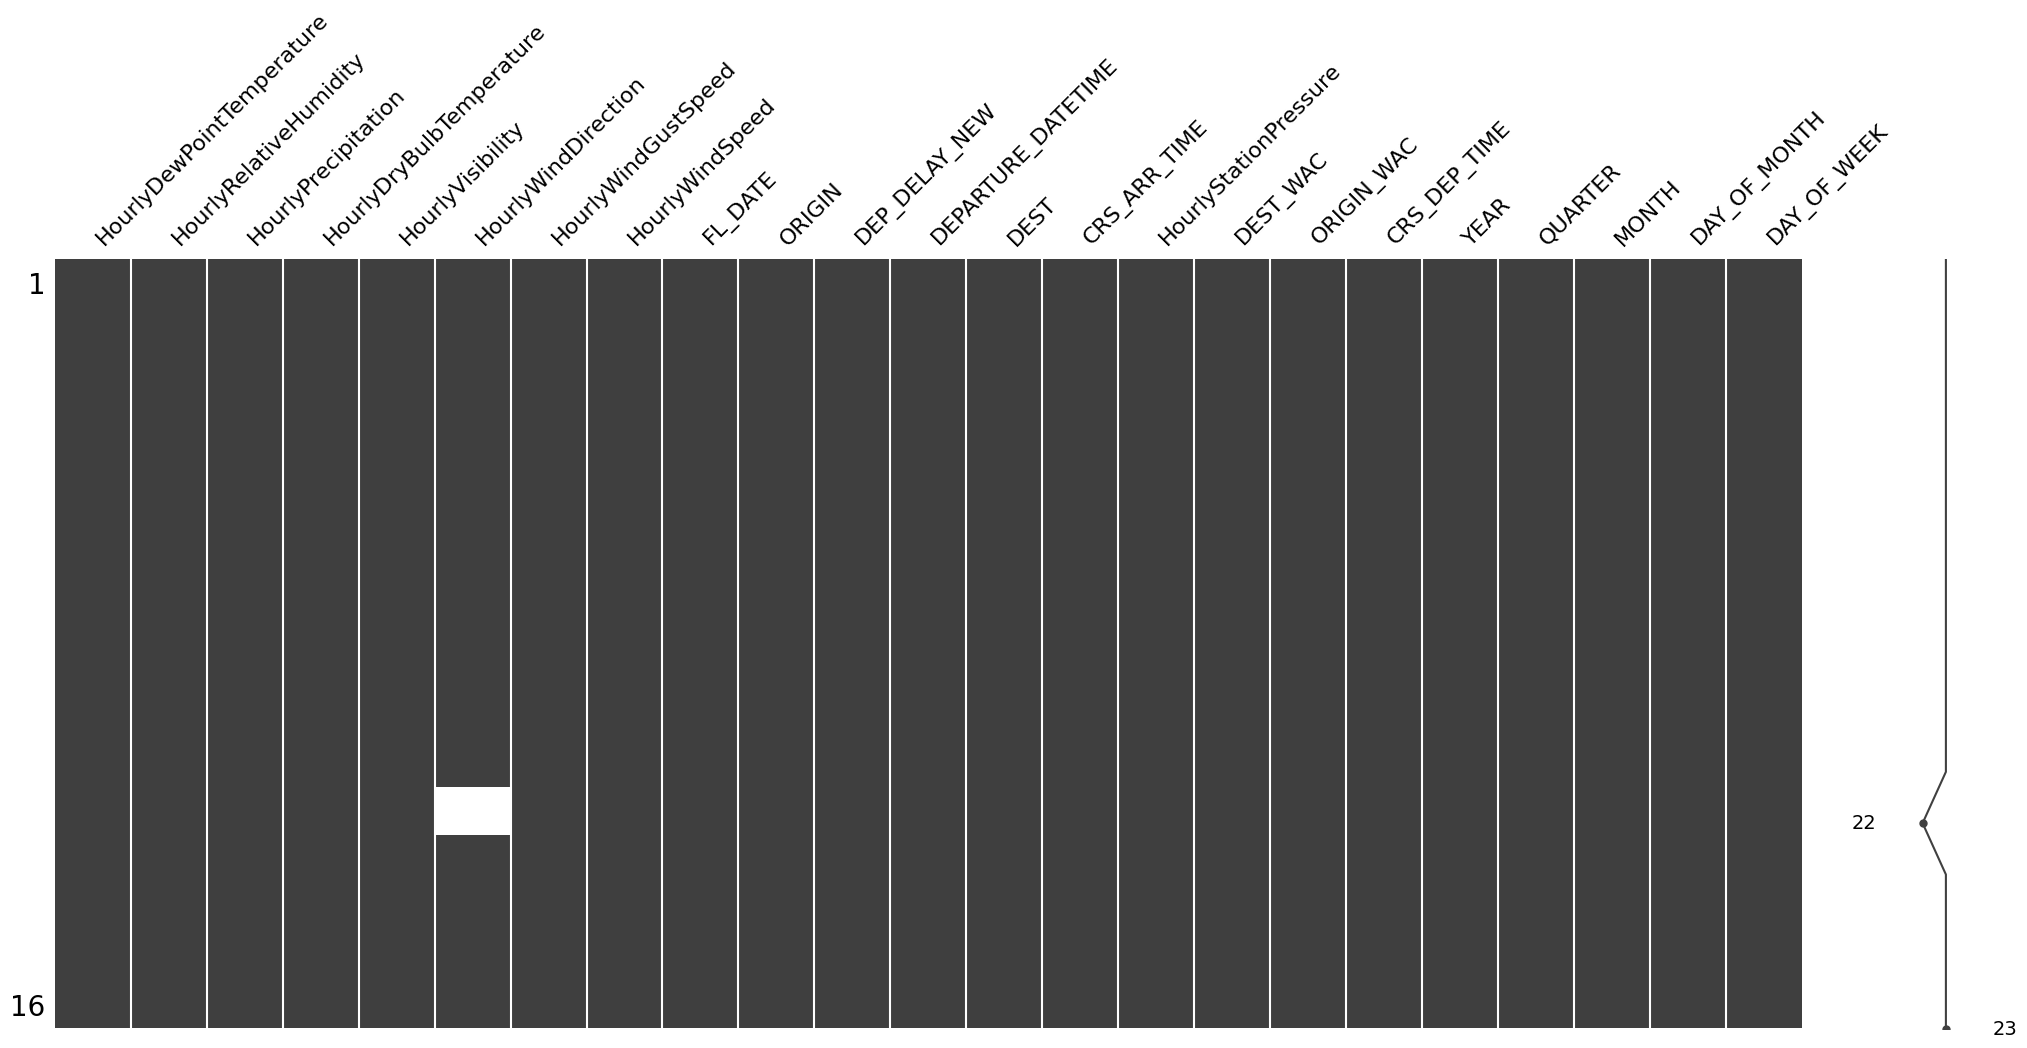

In [11]:
msno.matrix(weather_delay_data)

<Axes: >

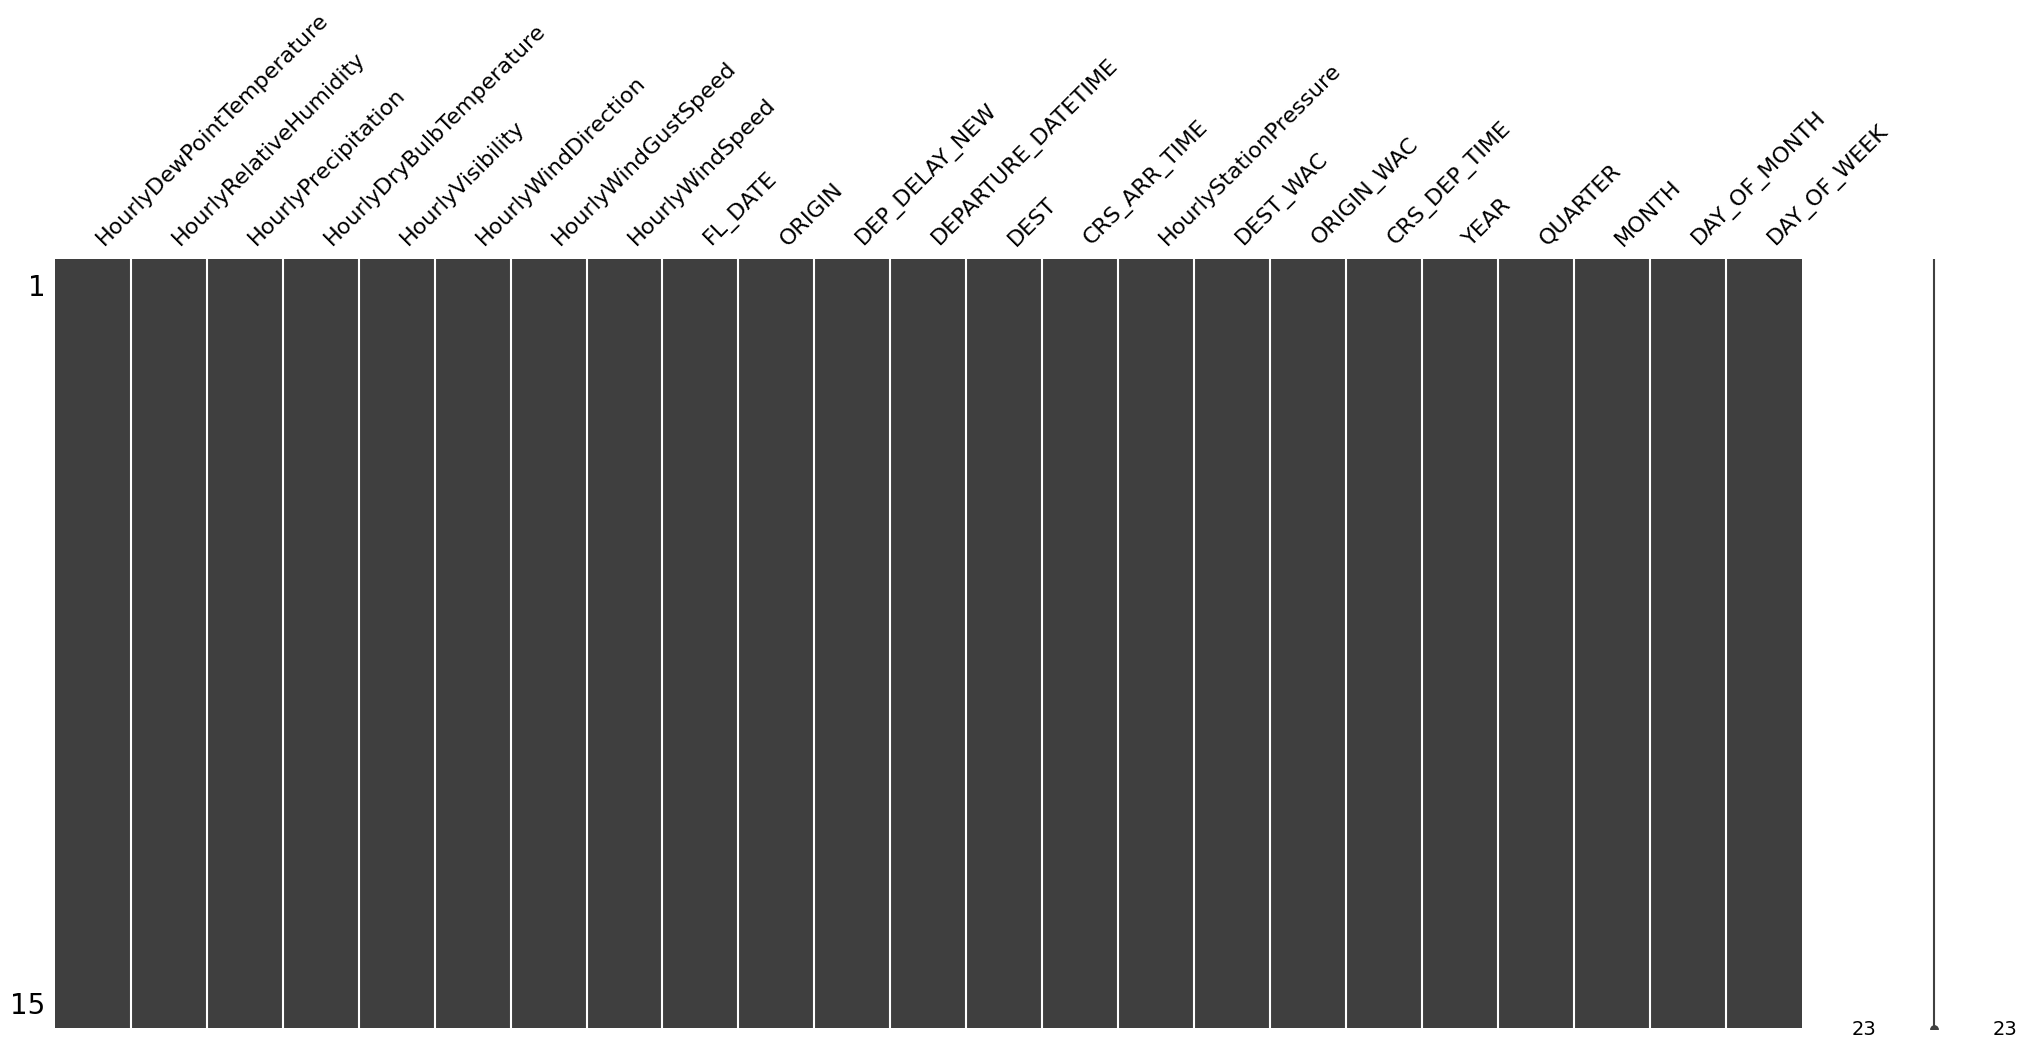

In [12]:
# remove rows with missing values
weather_delay_data = weather_delay_data.dropna()
msno.matrix(weather_delay_data)